https://rpubs.com/arquez9512/630415

## SMA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_csv('../datasets/AirPassengers.csv',  index_col = 'Month', parse_dates=True)
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<AxesSubplot: xlabel='Month'>

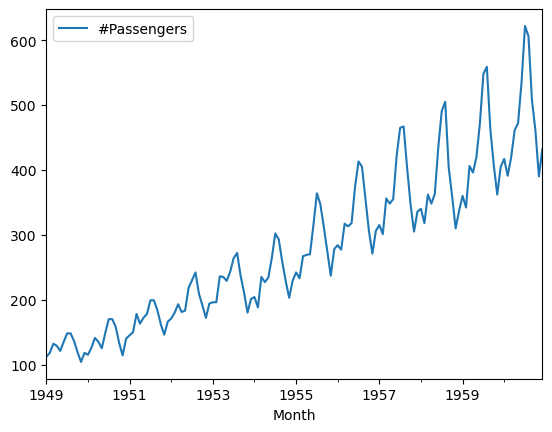

In [3]:
df.isna().sum()
df.plot()

<AxesSubplot: xlabel='Month'>

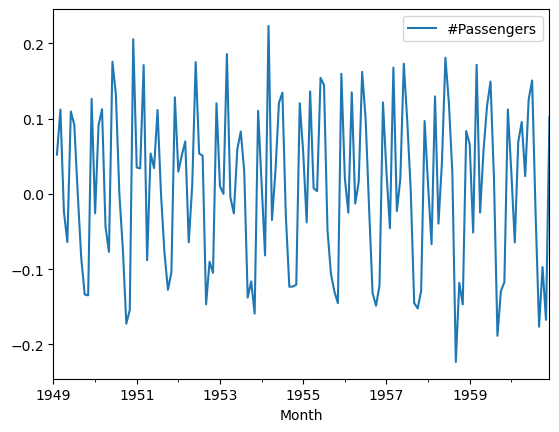

In [4]:
df_ret = np.log(df.pct_change(1) + 1)#pct_change: returns a DataFrame with the percentage difference between the values for each row and, by default, the previous row.

df_ret.plot()

<AxesSubplot: xlabel='Month'>

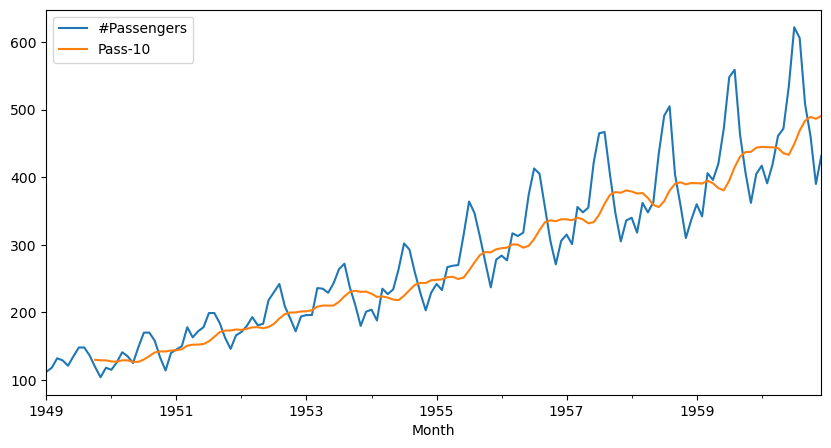

In [5]:
"""
SMA-> rolling: tamaño de la ventana,# de datos

      estadistica a considerar->mean  
"""
# mas suave, mientras mas valores se usen para promediar

df['Pass-10'] = df["#Passengers"].rolling(10).mean()
df.plot(figsize=(10, 5))

# EWMA

<AxesSubplot: xlabel='Month'>

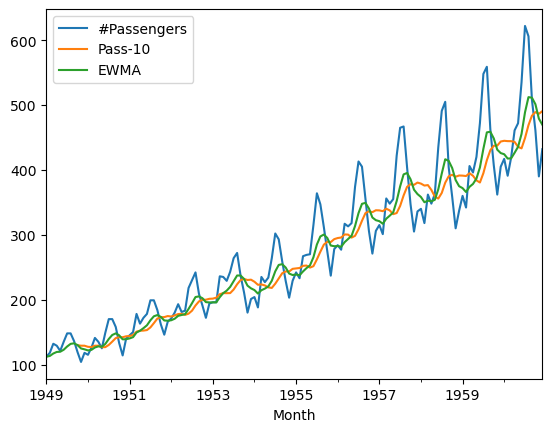

In [6]:
alpha = 0.2
df['EWMA'] = df['#Passengers'].ewm(alpha=alpha, adjust=False).mean()
df.plot()


<AxesSubplot: xlabel='Month'>

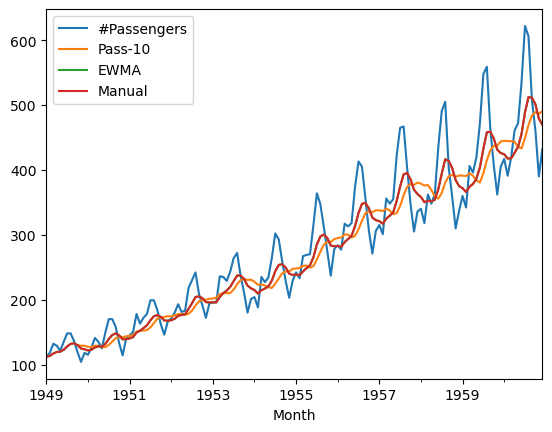

In [7]:
#Calcular EWMN manualmente
manual_ewma = []
for x in df['#Passengers'].to_numpy():
  if len(manual_ewma) > 0:
    xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
  else:
    xhat = x
  manual_ewma.append(xhat)
df['Manual'] = manual_ewma
df.plot()

In [8]:
df.drop('Manual', axis=1, inplace=True)


## Suaviamiento exponencial simple - SES (simple exponencial smoothing)

Este procedimiento es adecuado cuando los datos no tienen tendencia o patrón estacional. Los pesos de cada observación son determinados por un parametro de suavizamiento $\alpha$. Para un conjunto de datos con T
 observaciones , calculamos el valor predicho:

 \begin{equation}
 \hat{y}_{t+1} = \alpha y_t + \alpha(1-\alpha)y_{t-1}+\cdots+\alpha({1-\alpha})^{t-1}y_1
 \end{equation}

 Donde $0<\alpha <1$ puedes er visto como una tasa de aprendizaje. Valores cercanos a cero son considerados como aprendizaje lento ya que se da más peso a información histórica, mientra que valores cercanos a 1 son considerados como aprendizaje rápido porque el algoritmo da más peso a las observaciones recientes.

In [9]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [10]:
ses = SimpleExpSmoothing(df['#Passengers']) 


/home/isadoji/Storage/Software/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [11]:
df.index


DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [12]:
# fijar la frecuencia mensualmente
df.index.freq = 'MS'

In [13]:
ses = SimpleExpSmoothing(
    df['#Passengers'],
    initialization_method='legacy-heuristic')

In [14]:
# optimizar alpha para ajustar a los datos
res = ses.fit(smoothing_level=alpha, optimized=False)
res 


In [15]:
df['SES'] = res.predict(start=df.index[0], end=df.index[-1])
df['SES'] 

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Name: SES, Length: 144, dtype: float64

In [16]:
np.allclose(df['SES'], res.fittedvalues) #predict y fit son los mismos


True

<AxesSubplot: xlabel='Month'>

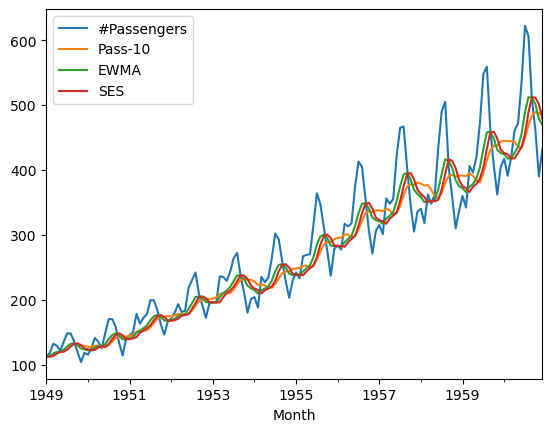

In [17]:
df.plot() #shift en 1


In [18]:
df.head()


,#Passengers,Pass-10,EWMA,SES
Month,,,,
1949-01-01,112,NaN,112.0000,112.000
1949-02-01,118,NaN,113.2000,112.000
1949-03-01,132,NaN,116.9600,113.200
1949-04-01,129,NaN,119.3680,116.960
1949-05-01,121,NaN,119.6944,119.368


In [19]:
df['SES-1'] = df['SES'].shift(-1) #wrong 

<AxesSubplot: xlabel='Month'>

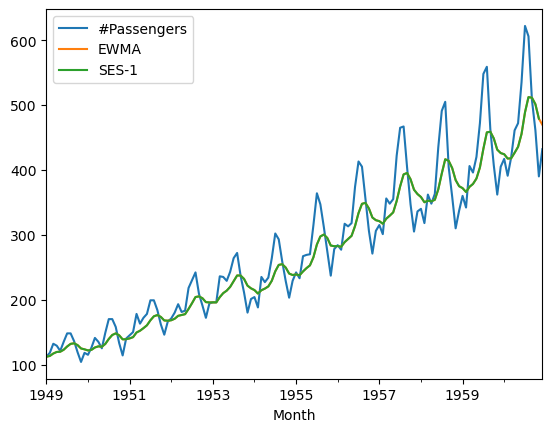

In [20]:
### No!
df[['#Passengers', 'EWMA', 'SES-1']].plot()

In [21]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [22]:
ses = SimpleExpSmoothing(
    train['#Passengers'],
    initialization_method='legacy-heuristic')
res = ses.fit()

In [23]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

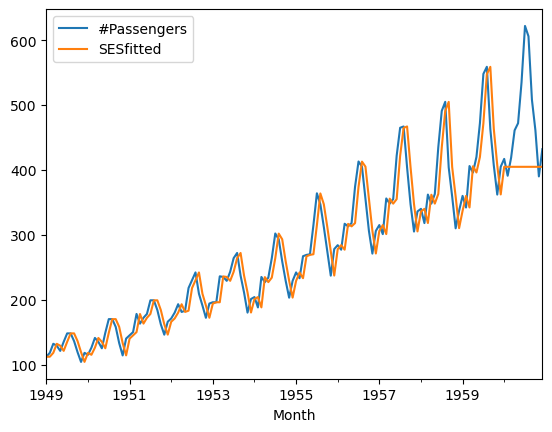

In [24]:
df.loc[train_idx, 'SESfitted'] = res.fittedvalues
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)
df[['#Passengers', 'SESfitted']].plot()

In [25]:
res.params #casi 1 

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

## Holt

<AxesSubplot: xlabel='Month'>

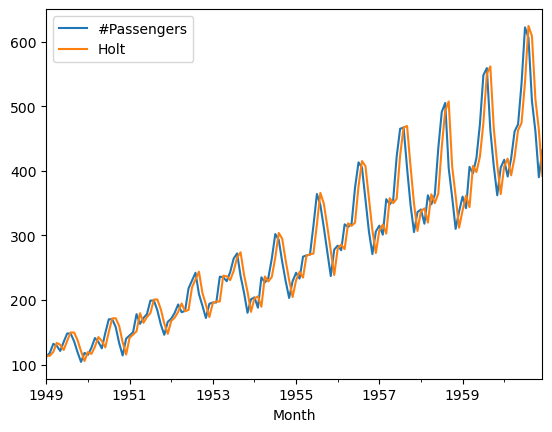

In [26]:
from statsmodels.tsa.holtwinters import Holt

holt = Holt(
    df['#Passengers'],
    initialization_method='legacy-heuristic')
res_h = holt.fit()
df['Holt'] = res_h.fittedvalues
df[['#Passengers', 'Holt']].plot()


<AxesSubplot: xlabel='Month'>

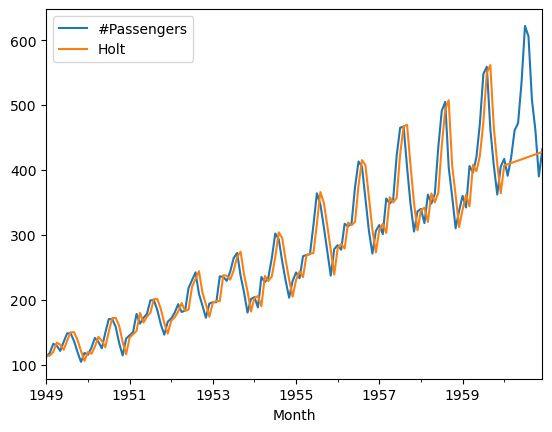

In [27]:
holt = Holt(train['#Passengers'], initialization_method='legacy-heuristic')
res_h = holt.fit()
df.loc[train_idx, 'Holt'] = res_h.fittedvalues
df.loc[test_idx, 'Holt'] = res_h.forecast(N_test)
df[['#Passengers', 'Holt']].plot()

# Holt-Winter

<AxesSubplot: xlabel='Month'>

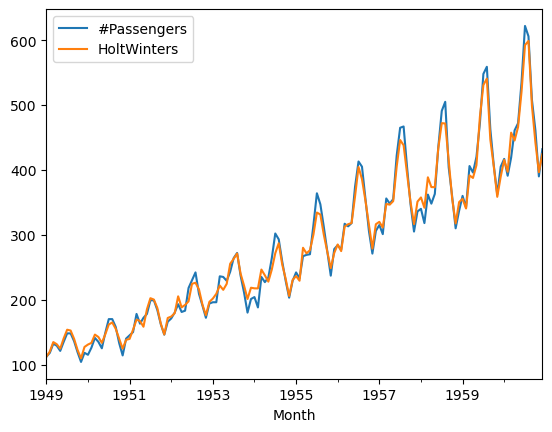

In [28]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#Add
hw = ExponentialSmoothing(
    train['#Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='add', seasonal_periods=12)
res_hw = hw.fit()
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['#Passengers', 'HoltWinters']].plot()

In [29]:
def rmse(y, t):
  return np.sqrt(np.mean((y - t)**2))
def mae(y, t):
  return np.mean(np.abs(y - t))

In [30]:
print("Train RMSE:", rmse(train['#Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['#Passengers'], res_hw.forecast(N_test)))
print("Train MAE:", mae(train['#Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['#Passengers'], res_hw.forecast(N_test)))

Train RMSE: 11.624714430673352
Test RMSE: 16.978029847029934
Train MAE: 9.006650631052384
Test MAE: 13.37759090303536


<AxesSubplot: xlabel='Month'>

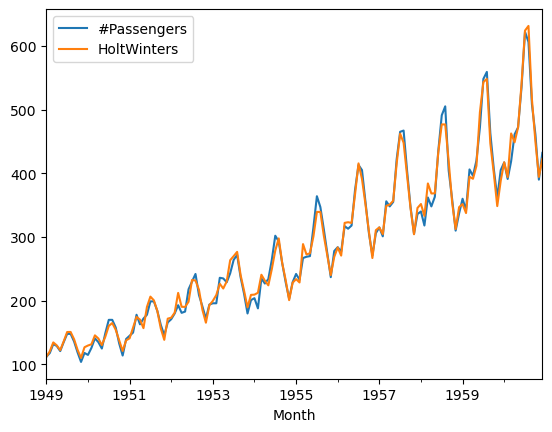

In [31]:
#Mult
hw = ExponentialSmoothing(
    train['#Passengers'],
    initialization_method='legacy-heuristic',
    trend='add', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['#Passengers', 'HoltWinters']].plot()


In [32]:
print("Train RMSE:", rmse(train['#Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['#Passengers'], res_hw.forecast(N_test)))
print("Train MAE:", mae(train['#Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['#Passengers'], res_hw.forecast(N_test)))

Train RMSE: 9.767995205168011
Test RMSE: 15.810870232569963
Train MAE: 7.604272329965027
Test MAE: 10.30368288348438


/home/isadoji/Storage/Software/miniconda3/envs/py310/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


<AxesSubplot: xlabel='Month'>

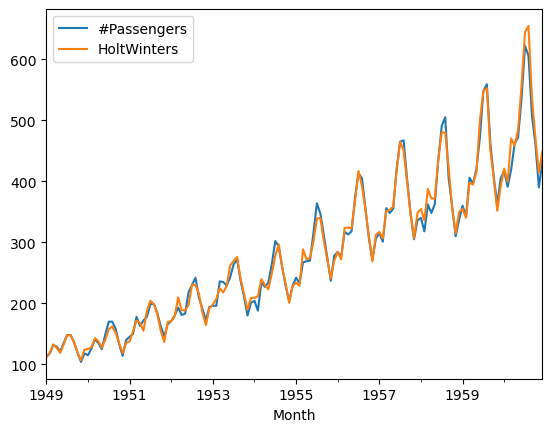

In [33]:
hw = ExponentialSmoothing(
    train['#Passengers'],
    initialization_method='legacy-heuristic',
    trend='mul', seasonal='mul', seasonal_periods=12)
res_hw = hw.fit()
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)
df[['#Passengers', 'HoltWinters']].plot()

In [34]:
print("Train RMSE:", rmse(train['#Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['#Passengers'], res_hw.forecast(N_test)))
print("Train MAE:", mae(train['#Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['#Passengers'], res_hw.forecast(N_test)))

Train RMSE: 9.61792487803932
Test RMSE: 25.80687515735493
Train MAE: 7.112379992634933
Test MAE: 20.844988412204554
